### PyTorch Implementation of Multilayer Perceptron for Calculating Molecular Energies

### Importing packages and helper functions

In [2]:
import pyanitools as pya
import pandas as pd
import numpy as np
import torch
from sys import exit
from pyanitools import anidataloader

### Install Torchani

In [3]:
!pip install torchani

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 12.2 MB/s eta 0:00:00


### Import Torchani AEVComputer for Data Processing

In [4]:
import torchani
from torchani import AEVComputer
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)

aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, ShfA, ShfZ, Zeta, num_species)

/usr/local/lib/python3.10/dist-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/usr/local/lib/python3.10/dist-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


### Set device to GPU for accelerated vector operations and training

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Define Torch Model for Multilayer Perceptron

In [6]:
import torch
from torch import nn

class ANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.sub_nets = nn.ModuleDict({
            "C" : ANI_sub(),
            "H" : ANI_sub(),
            "N" : ANI_sub(),
            "O" : ANI_sub()})
        #print(self.sub_nets)

    def forward(self, aevs, atom_types):
        #atomic_energies = [self.sub_nets[atom_types[i]](aevs[i]) for i in range(aevs.shape[1])]
        atomic_energies = [self.sub_nets[atom_types[i]](aevs[:, i, :]) for i in range(aevs.shape[1])]
        
        atomic_energies = torch.cat(atomic_energies, dim=1)
        total_energies = torch.sum(atomic_energies, dim=1)
        

        return total_energies

class ANI_sub(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.GELU(),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)
        return atomic_energy


### Define Function for Training and Validation

In [22]:
from sklearn.model_selection import train_test_split
def data_gen(X, y, S):
  mapping = {"H": 0, "C" : 1, "N": 2, "O": 3}
  species = np.array([mapping[atom] for atom in S])
  species = np.tile(species, (X.shape[0], 1))
  species = torch.tensor(species)
  X = torch.tensor(X)
  aev_output = aev_computer((species, X)) #SPecies: (Number, Atoms) A in [0, 1, 2, 3] Coords: (N, A, 3) Output : (N, A, 384)
  return aev_output[1], y

def evaluate(model, inputs, species, outputs):
 
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)

        loss_func = nn.MSELoss()
        pred = model.forward(inputs, species)
        losses = loss_func(pred, outputs)
        return losses

def train_and_test(data, model, epochs, learning_rate):

  val_losses = []

  for i in range(epochs):
    print("Epoch: ", i)
    for mol in data:
          #for mol in d:
          species = mol['species']
          #coords = np.array(mol['coordinates'])
          #energies = np.array(mol['energies'])
          # Do train test split here on coords
          X_train, X_test, y_train, y_test = train_test_split(mol['coordinates'], mol['energies'], test_size = 0.75)
          train_gen = data_gen(X_train, y_train, species) #compute AEVs
          test_gen = data_gen(X_test, y_test, species)
          #for train_X, train_y in train_gen:
              # train on one batch
          train_X = train_gen[0]
          train_y = train_gen[1]
          inputs = torch.tensor(train_X, dtype=torch.float32)
          outputs = torch.tensor(train_y, dtype=torch.float32)
          model = model
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

          
          weights = model.state_dict()
          model.train()

          batch_predictions = model.forward(inputs, species)
          loss_func = nn.MSELoss()
          loss = loss_func(batch_predictions, outputs)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

              
          #validation here
          test_X = test_gen[0]
          test_y = test_gen[1]
          val_loss = evaluate(model, test_X, species, test_y)
          #val_loss = 0
          val_losses.append(val_loss.detach().numpy())
  #test here after training finished
  return val_losses          


### Create the ANI Model, Load ANI Data, and Train the Model

In [20]:
model = ANI()
# Set the HDF5 file containing the data
hdf5file = 'ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)

losses_vector = train_and_test(adl, model, 30, 0.005)

Epoch:  0


<ipython-input-11-6091bcc15606>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(train_X, dtype=torch.float32)
<ipython-input-11-6091bcc15606>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


### Plot Validation Loss over the Training Epochs

90


Text(0, 0.5, 'MSE Loss')

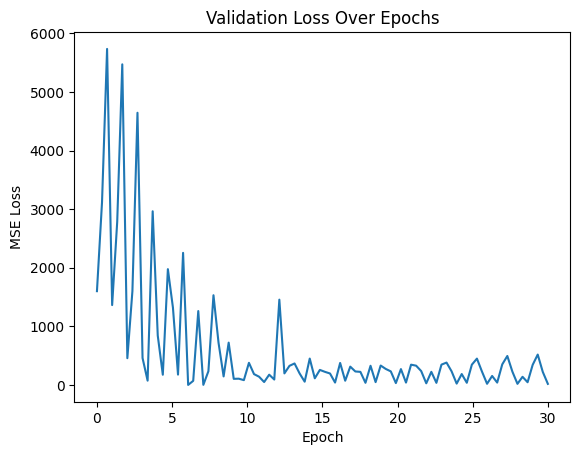

In [21]:
import matplotlib.pyplot as plt
print(len(losses_vector))

plt.plot(np.linspace(0, 30, 90), losses_vector)
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

In [34]:
data = anidataloader("ani_gdb_s01.h5")
data_iter = data.__iter__()
mols = next(data_iter)
# Extract the data
S = ''
sm = mols['smiles']
S = S.join(sm)
test_gen = data_gen(mols['coordinates'], mols['energies'], mols['species'])
X = test_gen[0]
y = test_gen[1]

mol_1_test_loss = evaluate(model, X, mols['species'], y)
print(f'MSE Loss on {S} data: {mol_1_test_loss}')

mols = next(data_iter)
# Extract the data'
S = ''
sm = mols['smiles']
S = S.join(sm)
test_gen = data_gen(mols['coordinates'], mols['energies'], mols['species'])
X = test_gen[0]
y = test_gen[1]

mol_2_test_loss = evaluate(model, X, mols['species'], y)
print(f'MSE Loss on {S} data: {mol_2_test_loss}')

mols = next(data_iter)
# Extract the data
S = ''
sm = mols['smiles']
S = S.join(sm)
test_gen = data_gen(mols['coordinates'], mols['energies'], mols['species'])
X = test_gen[0]
y = test_gen[1]

mol_3_test_loss = evaluate(model, X, mols['species'], y)
print(f'MSE Loss on {S} data: {mol_3_test_loss}')

<ipython-input-22-6091bcc15606>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


MSE Loss on [H]C([H])([H])[H] data: 264.22198486328125
MSE Loss on [H]N([H])[H] data: 10.494019508361816
MSE Loss on [H]O[H] data: 19.128007888793945
